In [3]:
import sys; sys.path.append('../../wwa'); from wwa import *

import statsmodels.nonparametric.smoothers_lowess as sm_lowess

# Somali floods

## Observed precip time series with smoother

In [5]:
chirps = pd.read_csv("MAM_CHIRPS_precip.csv", index_col = 0)
cpc = pd.read_csv("MAM_CPC_precip.csv", index_col = 0)
era5 = pd.read_csv("MAM_ERA5_precip.csv", index_col = 0)

era5 = era5.loc[slice(1979,None)]

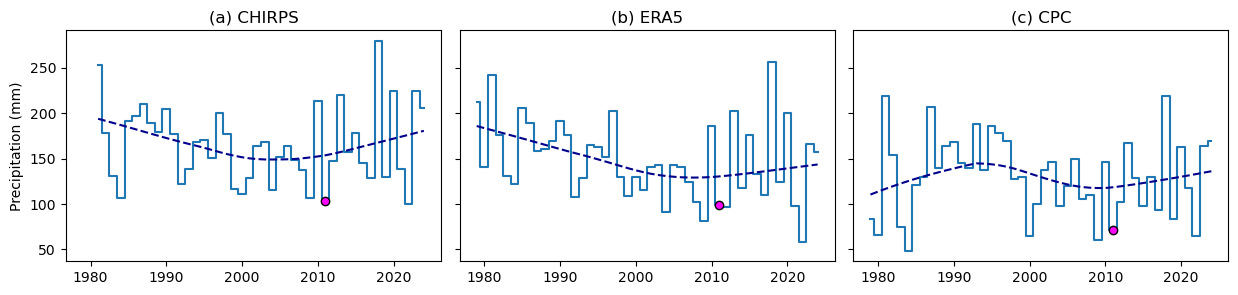

In [6]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(3):
    ds_nm = ["chirps", "era5", "cpc"][i]
    df = eval(ds_nm)
    ax = axs[i]
    
    ax.plot(df, drawstyle = "steps-mid")
    ax.plot(df.loc[[2011]], marker = "o", color = "magenta", mec = "k")
    
    ax.plot(df.index, sm_lowess.lowess(df.precip, df.index)[:,1], color = "darkblue", ls = "--")
    ax.set_title("("+"abcd"[i]+") "+ds_nm.upper())

axs[0].set_ylabel("Precipitation (mm)")
plt.savefig("fig_somali-floods_obs-mam-precip.png")

## ERA5 PEV & EV

In [15]:
# get ERA5 Penman-Monteith series
sf = gpd.read_file("sf_HoA/")

In [53]:
pev = xr.open_dataset("f64f0322c6f12bb1f6c1a73d6e3c6200.nc").pev.reset_coords(drop = True)
pev = pev.assign_coords(date = [pd.to_datetime(d, format='%Y%m%d').to_numpy() for d in pev.date]).rename(date = "time")
pev = convert_units_to(pev, "mm").sel(time = pev.time.dt.month.isin([3,4,5])).resample(time = "AS-JAN").sum()

pev = -pev.where(regionmask.mask_geopandas(sf, pev.longitude, pev.latitude) == 0).mean(["latitude", "longitude"]).sel(time = slice("1979", "2023"))
pev = pev.sel(time = slice("1979", None))

pev.assign_coords(time = pev.time.dt.year).rename("pet", time = "year").to_dataframe().to_csv("era5_pev_HoA.csv")

In [ ]:
ev = xr.open_dataset("908baef481cf4c42f936d5b7d9898bd5.nc").e.reset_coords(drop = True)
ev = ev.assign_coords(date = [pd.to_datetime(d, format='%Y%m%d').to_numpy() for d in ev.date]).rename(date = "time")
ev = convert_units_to(ev.assign_attrs(units = "m"), "mm", context = "hydro").resample(time = "AS-JAN").sum()

ev = -ev.where(regionmask.mask_geopandas(sf, ev.longitude, ev.latitude) == 0).mean(["latitude", "longitude"]).sel(time = slice("1979", "2023"))
ev = ev.sel(time = slice("1979", None))

ev.assign_coords(time = ev.time.dt.year).rename("evap", time = "year").to_dataframe().to_csv("era5_ev_HoA.csv")

In [ ]:
pev = xr.open_dataset("f64f0322c6f12bb1f6c1a73d6e3c6200.nc").pev.reset_coords(drop = True)
pev = pev.assign_coords(date = [pd.to_datetime(d, format='%Y%m%d').to_numpy() for d in pev.date]).rename(date = "time")

pev = convert_units_to(convert_units_to(pev, "mm").assign_attrs(units = "mm/day"), "mm/month")

pev = pev.sel(time = pev.time.dt.month.isin([10,11,12])).resample(time = "AS-JAN").sum()

pev = -pev.where(regionmask.mask_geopandas(sf, pev.longitude, pev.latitude) == 0).mean(["latitude", "longitude"]).sel(time = slice(None, "2023"))
pev.assign_coords(time = pev.time.dt.year).rename("pet", time = "year").to_dataframe().to_csv("CB_era5_pev_ond.csv")

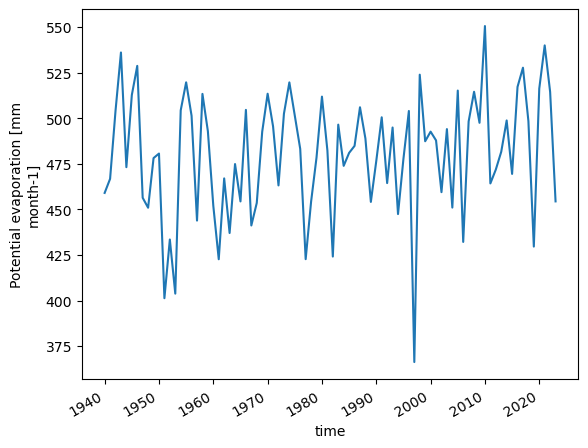

In [18]:
pev.plot()

## Compare PET time series


In [10]:
cpc = pd.read_csv("CPC_pet_HoA.dat", index_col = 0, comment = "#", sep = " ", header = None, names = ["year", "pet"]) * 92
era5 = pd.read_csv("ERA5_pet_HoA.dat", index_col = 0, comment = "#", sep = " ", header = None, names = ["year", "pet"]).loc[slice(1979,None)] * 92
pev = pd.read_csv("era5_pev_HoA.csv", index_col = 0)

In [11]:
def scale(ts): return (ts - ts.mean()) / ts.std()

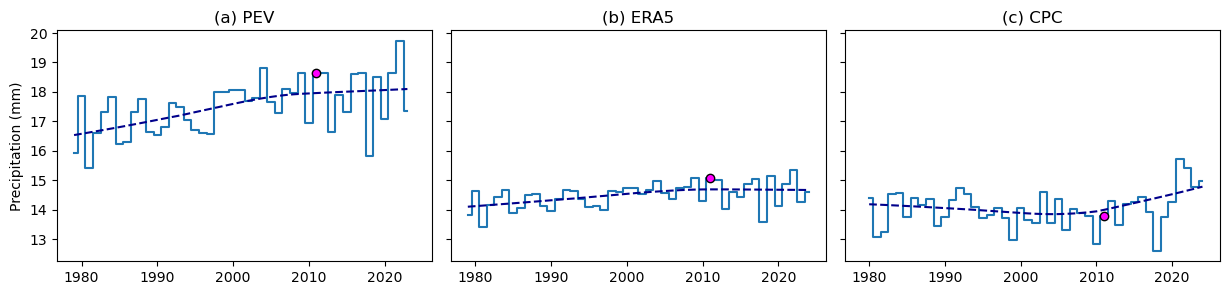

In [12]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(3):
    ds_nm = ["pev", "era5", "cpc"][i]
    df = eval(ds_nm)
    ax = axs[i]
    
    ax.plot(df, drawstyle = "steps-mid")
    ax.plot(df.loc[[2011]], marker = "o", color = "magenta", mec = "k")
    
    ax.plot(df.index, sm_lowess.lowess(df.pet, df.index)[:,1], color = "darkblue", ls = "--")
    ax.set_title("("+"abcd"[i]+") "+ds_nm.upper())

axs[0].set_ylim(0,)

axs[0].set_ylabel("Precipitation (mm)")
plt.savefig("fig_somali-floods_obs-mam-pet.png")

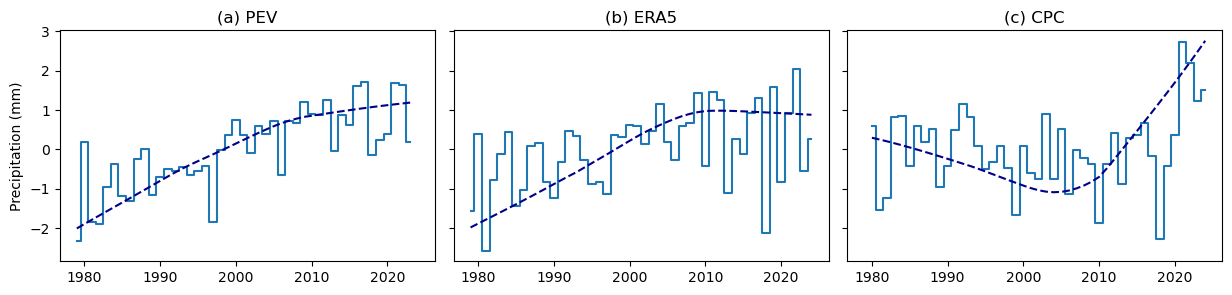

In [52]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(3):
    ds_nm = ["pev", "era5", "cpc"][i]
    df = eval(ds_nm)
    ax = axs[i]
    
    ax.plot(scale(df), drawstyle = "steps-mid")
    ax.plot(scale(df.loc[[2011]]), marker = "o", color = "magenta", mec = "k")
    
    ax.plot(df.index, scale(sm_lowess.lowess(df.pet, df.index)[:,1]), color = "darkblue", ls = "--")
    ax.set_title("("+"abcd"[i]+") "+ds_nm.upper())

axs[0].set_ylabel("Precipitation (mm)")
plt.savefig("fig_somali-floods_obs-mam-pet.png")

## Synthesis figures

In [49]:
def synth_plot(df, ax = None, logged = False, split_uw = False):
    
    # set split_uw = True to plot the unweighted mean of obs and models on its own line
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta"}
    
    ylabels = df.model.to_list()
    
    ax.grid(axis = "x", which = "major", color = "k", alpha = 0.1)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))
        ax.plot(r.est, -k, color = "k", marker = "v")
        
        if not (split_uw and df.index[k] == "synth"): 
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))
        else:
            k = k+1
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))
            if logged:
                uw_mean = np.exp((np.log(df.loc["obs_synth", "est"]) + np.log(df.loc["model_synth", "est"])) / 2)
            else:
                uw_mean = (df.loc["obs_synth", "est"] + df.loc["model_synth", "est"]) / 2
            ax.plot(uw_mean, -k, color = "k", marker = "v")
            ylabels = ylabels + ["unweighted mean"]

    ax.set_yticks(range(0, -len(ylabels), -1))
    ax.set_yticklabels(ylabels)

In [78]:
# load data

rnm = "somali-floods_pet2011"

di, pr = [pd.read_fwf(rnm+"_"+x+".txt", comment = "#", widths = [5,5,12,12,12,12,12,4,99], header = None,
            names = ["ystart", "yend", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"]) for x in ["dI", "PR"]]

# convert PET to mm/season
if "pet" in rnm:
    di[["est", "lower", "upper", "l_wb", "u_wb"]] = di[["est", "lower", "upper", "l_wb", "u_wb"]] * 92

di_lim = {"synthnew2013-rx4day" : (-50,100), "synthnew2024-rx4day" : (-50,100),
          "Nargis-2008" : (-100, 200), "Nargis-2024" : (-100, 200),
          "Sidr-2007" : (-100, 200), "Sidr-2024" : (-100, 200),
          "somali-floods_pet2011" : (-5,5), "somali-floods_pet2024" : (-5,5),
         }[rnm]

pr_lim = {"synthnew2013-rx4day" : (1e-3,1e7), "synthnew2024-rx4day" : (1e-3,1e7),
          "Nargis-2008" : (1e-3, 1e5), "Nargis-2024" : (1e-3, 1e5),
          "Sidr-2007" : (1e-1, 1e2), "Sidr-2024" : (1e-1, 1e2),
          "somali-floods_pet2011" : (1e-3, 1e7), "somali-floods_pet2024" : (1e-3, 1e7),
         }[rnm]

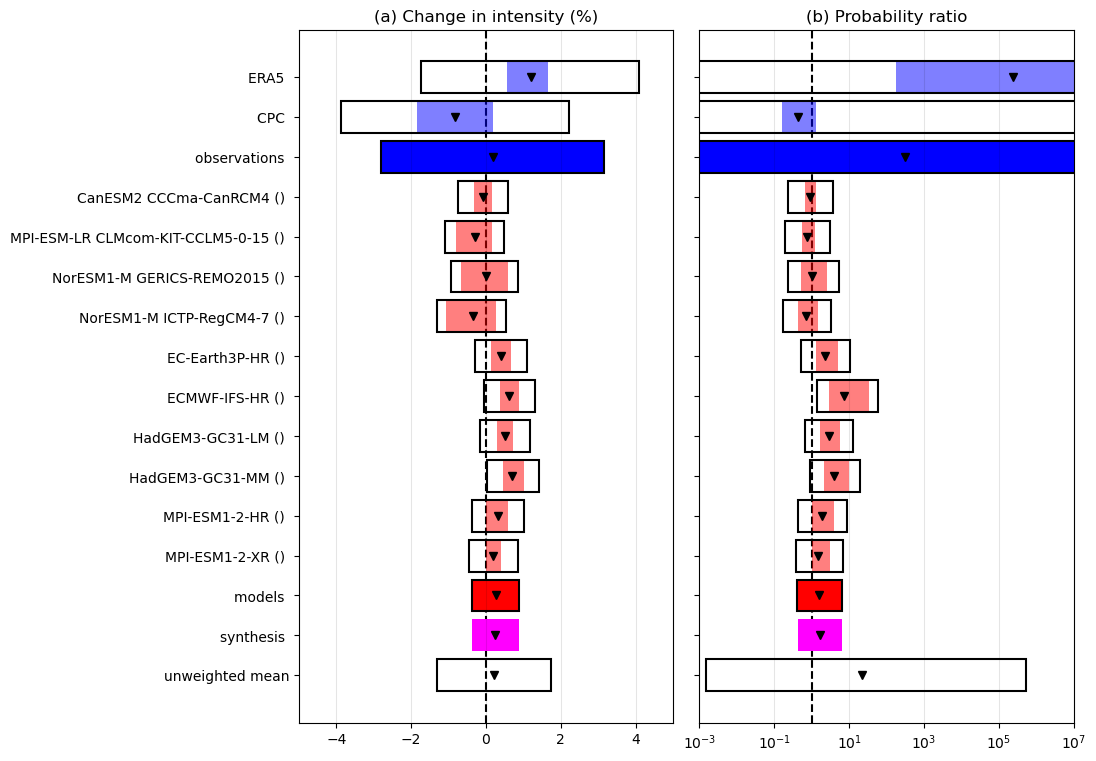

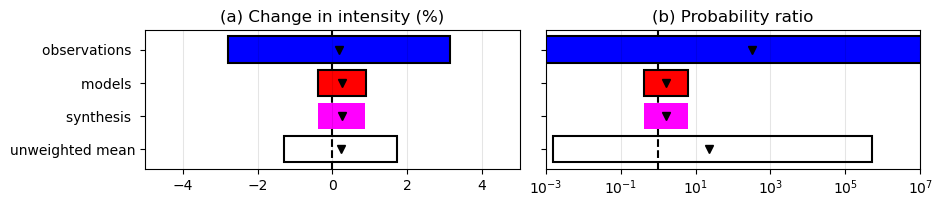

In [79]:
# fix group & model names
groups = [["obs","obs_synth","models","model_synth","synth"][i-1] for i in di.group]
di.index = groups; pr.index = groups

models = [re.sub("ETH-","",re.sub("UGent-","",re.sub("rcp85 r[0-9]+i1p1 ", "", re.sub(" \(1\) ","",re.sub('"','',m))))) for m in pr.model]
di["model"] = models; pr["model"] = models

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(di)*0.6), dpi = 100)
plt.subplots_adjust(wspace = 0.07)

synth_plot(di, ax = axs[0], split_uw = True)
axs[0].set_title("(a) Change in intensity (%)")
axs[0].set_xlim(di_lim)

synth_plot(pr, ax = axs[1], logged = True, split_uw = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim(pr_lim)

plt.savefig("synthesis_"+rnm+".png")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# trim down to just the summary rows
sdi, spr = [df.loc[["synth" in r for r in di.index]] for df in [di, pr]]

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(sdi)*0.6), dpi = 100)
plt.subplots_adjust(wspace = 0.07)

synth_plot(sdi, ax = axs[0], split_uw = True)
axs[0].set_title("(a) Change in intensity (%)")
axs[0].set_xlim(di_lim)

synth_plot(spr, ax = axs[1], logged = True, split_uw = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim(pr_lim)

plt.savefig("minisynthesis_"+rnm+".png")